# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
# when running in Udacity workspace
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.4 which is incompatible.


In [3]:
%load_ext autoreload
%autoreload 2

from maddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
from unityagents import UnityEnvironment

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [4]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:\n', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like:
 [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [7]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.09000000171363354


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!

### Constants

In [8]:
MAX_EPISODES = 2500
SOLVED_SCORE = 0.5    # FOR TESTING ONLY - should be 0.5
WINDOW_SIZE = 100       # FOR TESTING ONLY - should be 100
PRINT_EVERY = 10
ADD_NOISE = True
STOP_IF_NO_IMPROVEMENT_OVER_EPISODES = 300
RAND_SEED = 6

SAVE_DIR = 'saved_models_and_scores'

### Helper Functions

In [9]:
def get_actions(states, add_noise):
    # get all actions and flatten
    actions = [a.act(states, add_noise) for a in agents]
    return np.reshape(actions, (1, num_agents*action_size))

def reset_agents():
    for a in agents:
        a.reset()

def reset_rand_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

        
def learning_step(states, actions, rewards, next_states, done):
    for i, agent in enumerate(agents):
        agent.step(states, actions, rewards[i], next_states, done, i)

def save_weights(ep):
    for i, agent in enumerate(agents):
        torch.save(agent.actor_local.state_dict(), SAVE_DIR + '/actor_' + str(i) + '_ep_' + str(ep) + '.pth')
        torch.save(agent.critic_local.state_dict(), SAVE_DIR + '/critic_' + str(i) + '_ep_' + str(ep) + '.pth')


### Training Functions

In [10]:
def maddpg():

    # initialize scores
    scores_window = deque(maxlen=WINDOW_SIZE)
    scores_all = []
    moving_average = []
    best_score = -np.inf
    best_episode = 0
    env_solved = False

    for i_episode in range(1, MAX_EPISODES+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment
        states = np.reshape(env_info.vector_observations, (1,num_agents*state_size)) # flatten states
        reset_agents()
        scores = np.zeros(num_agents)
        while True:
            actions = get_actions(states, ADD_NOISE)           # choose agent actions and flatten them
            env_info = env.step(actions)[brain_name]           # send both agents' actions to the environment
            next_states = np.reshape(env_info.vector_observations, (1, num_agents*state_size)) # flatten next states
            rewards = env_info.rewards                         # get rewards
            done = env_info.local_done                         # see if the episode finished
            learning_step(states, actions, rewards, next_states, done)  # perform the learning step
            scores += np.max(rewards)                          # update scores with best reward
            states = next_states                               # roll over states to next time step
            if np.any(done):                                   # exit loop if episode finished
                break

        ep_best_score = np.max(scores)                         # record best score for episode
        scores_window.append(ep_best_score)                    # add score to recent scores
        scores_all.append(ep_best_score)                       # add score to histor of all scores
        moving_average.append(np.mean(scores_window))          # recalculate moving average

        # save best score
        if ep_best_score > best_score and ep_best_score > 0:
            best_score = ep_best_score
            best_episode = i_episode
            print('New best score found on episode {:d}; score = {:.3f}'.format(best_episode, best_score))
        
        # print results
        if i_episode % PRINT_EVERY == 0:
            print('Episodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode-PRINT_EVERY, i_episode, np.max(scores_all[-PRINT_EVERY:]), moving_average[-1]))

        # determine if environment is solved and keep best performing models
        if moving_average[-1] >= SOLVED_SCORE:
            if not env_solved:
                print('<<< Environment solved in {:d} episodes! \
                \n<<< Moving Average: {:.3f} over past {:d} episodes'.format(
                    i_episode-WINDOW_SIZE, moving_average[-1], WINDOW_SIZE))
                env_solved = True

                # save weights
                save_weights(i_episode)
                np.save(SAVE_DIR+'/scores.npy', scores_all)
                break

            elif ep_best_score >= best_score:
                print('<<< Best episode so far!\
                \nEpisode {:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode, ep_best_score, moving_average[-1]))

                # save weights
                save_weights()

            # stop training if model stops improving
            elif (i_episode-best_episode) >= STOP_IF_NO_IMPROVEMENT_OVER_EPISODES:
                print('<-- Training stopped. Best score not matched or exceeded for', STOP_IF_NO_IMPROVEMENT_OVER_EPISODES, 'episodes')
                break
            else:
                continue

    return scores_all, moving_average

### Run training loop

In [11]:
# reset random seed
# reset_rand_seed(RAND_SEED)

# make two agents
agents = [Agent(state_size, action_size, num_agents=1, random_seed=1) for i in range(num_agents)]

# run training loop
scores, avgs = maddpg()

New best score found on episode 5; score = 0.100
Episodes 0000-0010	Max Reward: 0.100	Moving Average: 0.030
Episodes 0010-0020	Max Reward: 0.100	Moving Average: 0.030
Episodes 0020-0030	Max Reward: 0.100	Moving Average: 0.030
Episodes 0030-0040	Max Reward: 0.100	Moving Average: 0.030
Episodes 0040-0050	Max Reward: 0.000	Moving Average: 0.024
Episodes 0050-0060	Max Reward: 0.100	Moving Average: 0.027
Episodes 0060-0070	Max Reward: 0.100	Moving Average: 0.024
Episodes 0070-0080	Max Reward: 0.100	Moving Average: 0.024
Episodes 0080-0090	Max Reward: 0.100	Moving Average: 0.024
Episodes 0090-0100	Max Reward: 0.100	Moving Average: 0.023
Episodes 0100-0110	Max Reward: 0.100	Moving Average: 0.024
New best score found on episode 114; score = 0.200
Episodes 0110-0120	Max Reward: 0.200	Moving Average: 0.026
Episodes 0120-0130	Max Reward: 0.100	Moving Average: 0.027
Episodes 0130-0140	Max Reward: 0.100	Moving Average: 0.030
New best score found on episode 142; score = 0.300
New best score found on

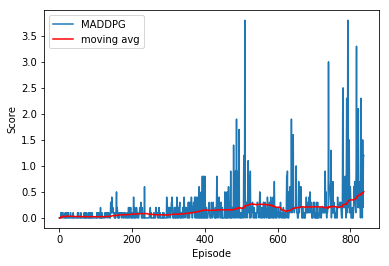

In [12]:
# plot scores and moving average
plt.figure()
plt.plot(scores, label='MADDPG')
plt.plot(avgs, c='r', label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.legend(loc='upper left')
plt.show()


### 5. Test a saved agent

In [ ]:
WINDOW_SIZE = 10
PRINT_EVERY = 1
ADD_NOISE = False

In [ ]:
## reinitialize the agents (if needed)
saved_ep = 838

agent_0 = Agent(state_size, action_size, num_agents=1, random_seed=0)
agent_1 = Agent(state_size, action_size, num_agents=1, random_seed=0)

# load the weights from file
agent_0_weights = SAVE_DIR + '/actor_0_ep_' + str(saved_ep) + '.pth'
agent_1_weights = SAVE_DIR + '/actor_1_ep_' + str(saved_ep) + '.pth'
agent_0.actor_local.load_state_dict(torch.load(agent_0_weights))
agent_1.actor_local.load_state_dict(torch.load(agent_1_weights))     

In [ ]:
def test(n_episodes=10, max_t=1000, train_mode=False):

    scores_window = deque(maxlen=WINDOW_SIZE)
    scores_all = []
    moving_average = []  

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]         # reset the environment
        states = np.reshape(env_info.vector_observations, (1,48)) # get states and combine them
        scores = np.zeros(num_agents)
        while True:
            actions = get_actions(states, ADD_NOISE)           # choose agent actions and combine them
            env_info = env.step(actions)[brain_name]           # send both agents' actions together to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine the agent next states
            rewards = env_info.rewards                         # get reward
            done = env_info.local_done                         # see if episode finished
            scores += np.max(rewards)                          # update the score for each agent
            states = next_states                               # roll over states to next time step
            if np.any(done):                                   # exit loop if episode finished
                break

        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        moving_average.append(np.mean(scores_window))

        # print results
        if i_episode % PRINT_EVERY == 0:
            print('Episodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode-PRINT_EVERY, i_episode, np.max(scores_all[-PRINT_EVERY:]), moving_average[-1]))
            
    return scores_all, moving_average            

In [ ]:
scores, avgs = test()

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='MADDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()

When finished, you can close the environment.

In [ ]:
env.close()